In [1]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from hamiltonian_diff import model
from cell_typing import CellKind, CellMap

In [2]:
grid = t.zeros((1,5,5))
grid[0,1,2] = 1
grid[0,2,1] = 1
grid[0,2,2] = 1
grid[0,2,3] = 1
grid[0,3,2] = 1
print(grid)

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])


In [3]:
target_perim1 = t.tensor(10.)
lambda_perim1 = t.tensor(1.)
target_vol1 = t.tensor(7.)
lambda_vol1 = t.tensor(1.)
adh_cost1 = {0: 2.}
cell1 = CellKind(
    type_id=1,
    target_perimeter=target_perim1,
    lambda_perimeter=lambda_perim1,
    target_volume=target_vol1,
    lambda_volume=lambda_vol1,
    adhesion_cost=adh_cost1
)
cell_map = CellMap()
cell_map.add(cell_id=1, cell_type=cell1)

temperature = t.tensor(27.)

In [4]:
grid, stats = model(grid, cell_map, temperature)

In [5]:
print(stats["src_pixel"])
print(stats["target_pixel"])
print(stats["current"])
print(stats["adjusted"])
print(stats["h_diff"])
print(stats["p_copy"])
print(stats["success"])
print(grid)

[[0 1 2]]
[[0 0 1]]
{'volume_energy': tensor([4.]), 'perimeter_energy': tensor([196.]), 'adh_e': tensor([48.]), 'h': tensor([248.])}
{'volume_energy': tensor([1.]), 'perimeter_energy': tensor([400.]), 'adh_e': tensor([60.]), 'h': tensor([461.])}
tensor([213.])
tensor([0.0004])
tensor(1.)
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])


In [6]:
from hamiltonian_diff import hamiltonian_energy

target_vol1.requires_grad_()
e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
grad = t.autograd.grad(e, target_vol1)

In [7]:
grad

(tensor(2.),)

In [8]:
print(grid)
vols = t.linspace(1, 10, 10)

grads = []
for vol in vols:
    vol.requires_grad_()
    cell1 = CellKind(
        type_id=1,
        target_perimeter=target_perim1,
        lambda_perimeter=lambda_perim1,
        target_volume=vol,
        lambda_volume=lambda_vol1,
        adhesion_cost=adh_cost1
    )
    cell_map = CellMap()
    cell_map.add(cell_id=1, cell_type=cell1)
    e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
    grad = t.autograd.grad(e, vol)[0]
    grads.append(grad.detach().numpy())
print(grads)

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])
[array(-10., dtype=float32), array(-8., dtype=float32), array(-6., dtype=float32), array(-4., dtype=float32), array(-2., dtype=float32), array(0., dtype=float32), array(2., dtype=float32), array(4., dtype=float32), array(6., dtype=float32), array(8., dtype=float32)]


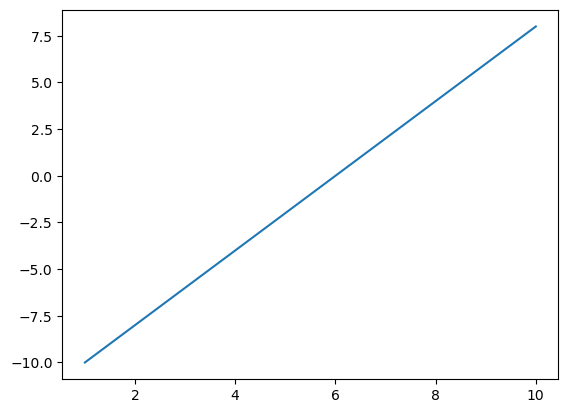

In [10]:
plt.plot(vols, grads)

In [11]:
for idx, vol in enumerate(vols):
    print(f"{vol}: {grads[idx]}")

1.0: -10.0
2.0: -8.0
3.0: -6.0
4.0: -4.0
5.0: -2.0
6.0: 0.0
7.0: 2.0
8.0: 4.0
9.0: 6.0
10.0: 8.0


In [13]:
print(grid)
perims = t.linspace(1, 100, 100)

grads = []
for perim in perims:
    perim.requires_grad_()
    cell1 = CellKind(
        type_id=1,
        target_perimeter=perim,
        lambda_perimeter=lambda_perim1,
        target_volume=target_vol1,
        lambda_volume=lambda_vol1,
        adhesion_cost=adh_cost1
    )
    cell_map = CellMap()
    cell_map.add(cell_id=1, cell_type=cell1)
    e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
    grad = t.autograd.grad(e, perim)[0]
    grads.append(grad.detach().numpy())
print(grads)

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])
[array(-58., dtype=float32), array(-56., dtype=float32), array(-54., dtype=float32), array(-52., dtype=float32), array(-50., dtype=float32), array(-48., dtype=float32), array(-46., dtype=float32), array(-44., dtype=float32), array(-42., dtype=float32), array(-40., dtype=float32), array(-38., dtype=float32), array(-36., dtype=float32), array(-34., dtype=float32), array(-32., dtype=float32), array(-30., dtype=float32), array(-28., dtype=float32), array(-26., dtype=float32), array(-24., dtype=float32), array(-22., dtype=float32), array(-20., dtype=float32), array(-18., dtype=float32), array(-16., dtype=float32), array(-14., dtype=float32), array(-12., dtype=float32), array(-10., dtype=float32), array(-8., dtype=float32), array(-6., dtype=float32), array(-4., dtype=float32), array(-2., dtype=float32), array(0., dtype=float32), array(2.

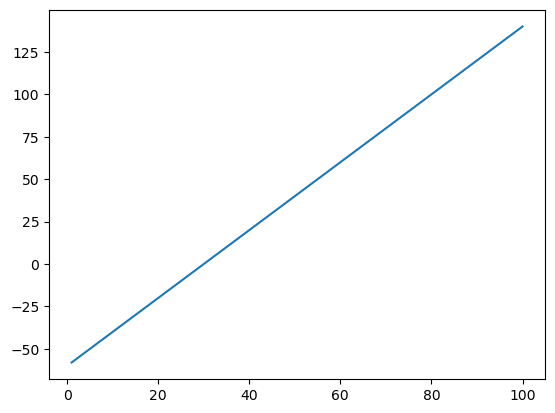

In [15]:
plt.plot(perims, grads)